In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np
from plotting_utils import *

In [2]:
data_path = 'output_data/btes_base_case_orca'

color_map = {
    'solar': '#FDB845',
    'wind': '#74CBCA',
    'battery': '#6F4E7C',
    'natgas': 'gray',
    'oil': 'black',
    'hydrogen': '#F6A3AD',
    'BTES': '#BF3B3D',
    'load': '#0B84A5',
    'lost_load': '#9DD866',}

In [3]:
def read_file(file_path):
    """
    Read the pickle file and return the data, averaging over 5 days to smooth curves
    """
    with open(file_path, 'rb') as f:
        result_data = pickle.load(f)
    f.close()
    # Average over 5 days
    result_data['time results'] = result_data['time results'].resample('5D').mean()
    return result_data

In [4]:
def get_cost_contributions(datapath, filename):
    """
    Get the cost contributions of the different technologies from the pickle file.
    """
    with open(os.path.join(datapath, filename), 'rb') as f:
        data = pickle.load(f)

        component_data = data['component results']
        # Add by carrier
        component_data_carrier = component_data.groupby('carrier').sum()
        cost = component_data_carrier['Capital Expenditure [$]'] + component_data_carrier['Operational Expenditure [$]']
        # Print out system cost per demand
        total_met_demand = component_data['Withdrawal [MW]']['Load'].sum()
        if ('fossil' in filename and ('1p0.' in filename or '1p32' in filename)) or ('wind_solar' in filename and '1p65' in filename):
            print("File:", filename)
            print("Total system cost per met demand: ", cost.sum()/total_met_demand)
        # Divide by total met demand i.e. withdrawal of load
        total_met_demand = component_data['Withdrawal [MW]']['Load'].sum()
        # Drop load
        cost = cost.drop('load')
        # Group BTES_charger, BTES_discharger and granite into BTES
        cost = cost.groupby(lambda x: 'BTES' if ('BTES' in x or 'granite' in x) else x).sum()
    # Close the file
    f.close()
    return cost, total_met_demand
            

In [5]:
def get_energy_stored(result_data, mean_demand):
    """
    Get the energy stored in the different storage technologies in terms of days of mean demand.
    """
    energy_stored_btes = result_data['time results']['granite e']/mean_demand/24
    energy_stored_hydrogen = result_data['time results']['hydrogen storage underground e']/mean_demand/24
    energy_stored_battery = result_data['time results']['Lithium-Ion-LFP-store e']/mean_demand/24

    return energy_stored_btes, energy_stored_hydrogen, energy_stored_battery

In [6]:
def get_discharger_dispatch(result_data, mean_demand):
    """
    Get the discharger dispatch of the different storage technologies.
    """
    discharger_dispatch_btes = result_data['time results']['BTES_discharger dispatch']#/mean_demand
    return discharger_dispatch_btes

In [7]:
def get_sources_sinks(result_data, mean_demand):
    """
    Get the electricity sources and sinks of the system.
    """
    # Get all dispatch data
    dispatch = result_data['time results'].filter(like='dispatch').rename(columns=lambda x: x.replace(' dispatch', ''))
    # Rename with key in color_map if it exists
    dispatch = dispatch.rename(columns={'solar-utility': 'solar', 'onwind':'wind', 'CCGT':'natgas'})
    # Print dispatch
    print("Discharger dispatch", dispatch["BTES_discharger"].sum())
    # Dispatch sources are all except electrolysis, battery charger, BTES charger; and load
    dispatch_sources = dispatch.drop(['electrolysis', 'Lithium-Ion-LFP-bicharger', 'BTES_charger'], axis=1)
    # Rename dispatch sources
    dispatch_sources = dispatch_sources.rename(columns={'fuel cell': 'hydrogen', 'Lithium-Ion-LFP-bicharger % discharge': 'battery', 'BTES_discharger':'BTES'})
    dispatch_sources /= mean_demand
    # Order by following order: wind, solar, natgas, BTES, oil, hydrogen, battery
    dispatch_sources = dispatch_sources[['wind', 'solar', 'natgas', 'BTES', 'oil', 'hydrogen', 'battery']]

    # Dispatch sinks are electrolysis, battery charger, BTES charger; and load
    dispatch_chargers = dispatch[['electrolysis', 'Lithium-Ion-LFP-bicharger', 'BTES_charger']]
    load = result_data['time results']['load load']
    dispatch_sinks = pd.concat([load, dispatch_chargers], axis=1)
    dispatch_sinks = dispatch_sinks.rename(columns={'load load': 'load', 'electrolysis': 'hydrogen', 'Lithium-Ion-LFP-bicharger': 'battery', 'BTES_charger': 'BTES'})
    dispatch_sinks = (dispatch_sinks/mean_demand) * (-1)
    # Order columns by increasing integral
    dispatch_sinks = dispatch_sinks[dispatch_sinks.sum().sort_values(ascending=True).index]
    
    return dispatch_sources, dispatch_sinks

In [8]:
def plot_cost_scan(data_path, region, tech):
    """
    Plot the cost scan of tech.
    """

    fig, ax = plt.subplots()
    system_cost = []
    file_names = [f for f in os.listdir(data_path) if (f.endswith('.pickle') and tech+'_costs' in f)]
    for btes_file in file_names:
        btes_discharge_cost = btes_file.split('_')[-1].split('.')[0]
        btes_discharge_cost = btes_discharge_cost.replace('costsx', '').replace('p', '.')

        syst_cost, demand = get_cost_contributions(data_path, btes_file)
        cost_per_demand = syst_cost / demand
        system_cost.append((float(btes_discharge_cost)*100, cost_per_demand))

    # Sort by cost factor
    system_cost = sorted(system_cost, key=lambda x: float(x[0]))
    
    # Collect data for stackplot
    x_values = []
    stack_data = {}
    for x_value, cost in system_cost:
        # Sort cost components
        cost = cost.sort_values(ascending=False)
        x_values.append(x_value)
        for name, cost_value in cost.items():
            if name not in stack_data:
                stack_data[name] = []
            stack_data[name].append(cost_value)

    # Order by following order: wind, solar, natgas, BTES, oil, hydrogen, battery
    stack_labels_order = ['wind', 'solar', 'natgas', 'BTES', 'oil', 'hydrogen', 'battery', 'lost_load']
    sorted_stack_labels = [label for label in stack_labels_order if label in stack_data]
    sorted_stack_values = [stack_data[label] for label in sorted_stack_labels if label in stack_data]

    # Plot stacked area
    ax.stackplot(
        x_values,
        *sorted_stack_values,
        labels=sorted_stack_labels,
        colors=[color_map[label] for label in sorted_stack_labels]
    )

    # x-axis
    ax.set_xlabel('of current {} costs'.format(tech.replace("wind_solar","wind and solar").replace("_"," ") if tech != 'BTES' else 'underground thermal storage'), fontsize=16)
    ax = x_labeling(ax, tech, x_values, fontsize=15)
    ax.set_xlim(0, x_values[-1])

    # y-axis
    ax.set_ylabel('System cost\n[$/MWh met demand]', fontsize=16)
    ax.set_yticks(ax.get_yticks())  # Keep default ticks but adjust formatting
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(0, 55)

    # Add legend with unique names
    handles, labels = ax.get_legend_handles_labels()
    labels = [label.replace('_', ' ') for label in labels]
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    # Save figure
    os.makedirs(f'figures/{region}', exist_ok=True)
    add_label = '_no_btes' if 'no_btes' in data_path else ''
    fig.savefig(f'figures/{region}/cost_scan_{tech}{add_label}.pdf', bbox_inches='tight')

In [9]:
def energy_stored_plot(result_data, cost, reg, scan_var, discharge_power=False, results2=None):
    """
    Make plots for energy in storage and charge/discharge power
    """

    mean_demand = result_data['time results']['load load'].mean()

    if not discharge_power:
        energy_stored_btes, energy_stored_hydrogen, energy_stored_battery = get_energy_stored(result_data, mean_demand)
    else:
        energy_stored_btes = get_discharger_dispatch(result_data, mean_demand)
        mean_demand2 = results2['time results']['load load'].mean()
        dispatch2 = get_discharger_dispatch(results2, mean_demand2)

    plt.figure()
    plt.plot(energy_stored_btes.index, energy_stored_btes, color=color_map['BTES'], label='BTES')
    if not discharge_power:
        plt.plot(energy_stored_hydrogen.index, energy_stored_hydrogen, color=color_map['hydrogen'], label='hydrogen')
        plt.plot(energy_stored_battery.index, energy_stored_battery, color=color_map['battery'], label='battery')
    if results2:
        plt.plot(dispatch2.index, dispatch2, color='blue', linestyle='--', label='BTES (2nd case)')
    # x-axis
    plt.xlabel('Date', fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.xlim(energy_stored_btes.index[0], energy_stored_btes.index[-1])
    # y-axis
    if not discharge_power:
        ylabel = 'Energy stored\n(days of mean demand)'
        plt.ylim(0,100.)
    else:
        ylabel = 'Discharge power per\nmean demand [MW/MW]'
    plt.ylabel(ylabel, fontsize=16)
    plt.yticks(fontsize=13)
    # Legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    plt.title(f"{scan_var}")
    # Save figure
    plt.savefig('figures/{0}/energy_stored_{1}_{2}.pdf'.format(reg, scan_var.split(" ")[0], cost), bbox_inches='tight')

In [10]:
def dispatch_plots(result_data, cost, reg, scan_var):
    """
    Make plots for dispatch sources and sinks
    """

    mean_demand = result_data['time results']['load load'].mean()
    dispatch_sources, dispatch_sinks = get_sources_sinks(result_data, mean_demand)

    plt.figure()
    y_sources = np.vstack([source for source in dispatch_sources.values.T])
    y_sinks = np.vstack([sink for sink in dispatch_sinks.values.T])
    plt.stackplot(dispatch_sources.index, y_sources, colors=[color_map[source] for source in dispatch_sources.columns], labels=dispatch_sources.columns)
    plt.stackplot(dispatch_sinks.index, y_sinks, colors=[color_map[sink] for sink in dispatch_sinks.columns], labels=dispatch_sinks.columns)
    # x-axis
    plt.xlabel('Date', fontsize=16)
    plt.xticks(fontsize=13, rotation=45)
    plt.xlim(dispatch_sources.index[0], dispatch_sources.index[-1])
    # y-axis
    plt.ylabel('Dispatch per\nmean demand [MW/MW]', fontsize=16)
    plt.yticks(fontsize=13)
    plt.ylim(-2, 2)
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [label.replace('_', ' ') for label in labels]
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    # Save figure
    plt.savefig('figures/{0}/dispatch_{1}_{2}.pdf'.format(reg, scan_var.split(" ")[0], cost), bbox_inches='tight')

File: btes_output_wind_solar_costsx1p65.pickle
Total system cost per met demand:  53.42834897831463
File: btes_output_fossil_costsx1p0.pickle
Total system cost per met demand:  44.00786977085631
File: btes_output_fossil_costsx1p32.pickle
Total system cost per met demand:  45.06013458875924
File: btes_output_no_btes_wind_solar_costsx1p65.pickle
Total system cost per met demand:  53.43918644295421
File: btes_output_no_btes_fossil_costsx1p32.pickle
Total system cost per met demand:  49.52301595908015


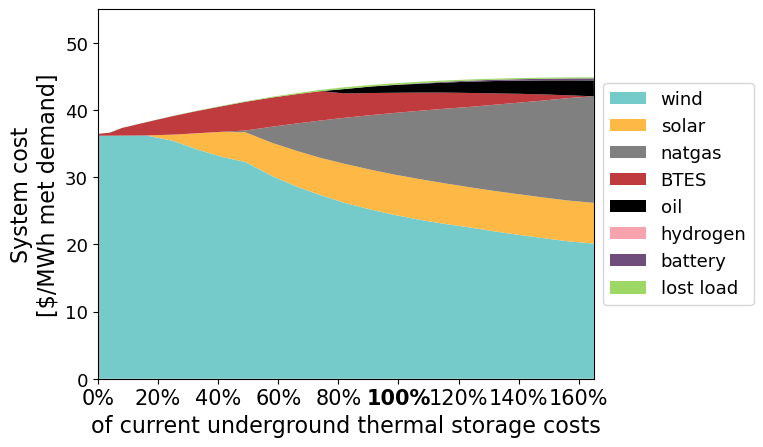

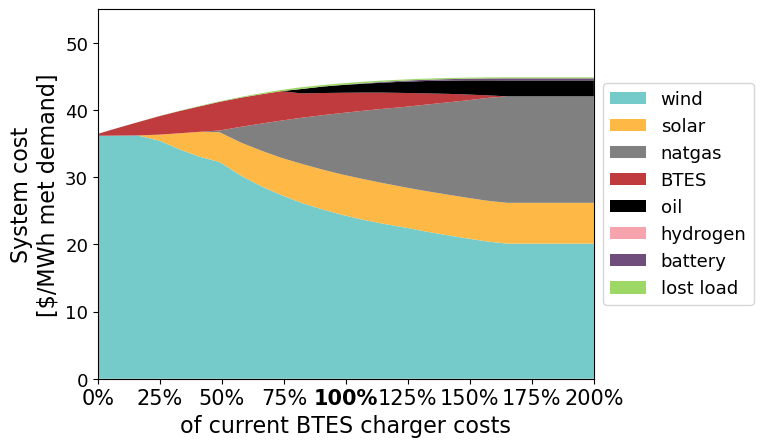

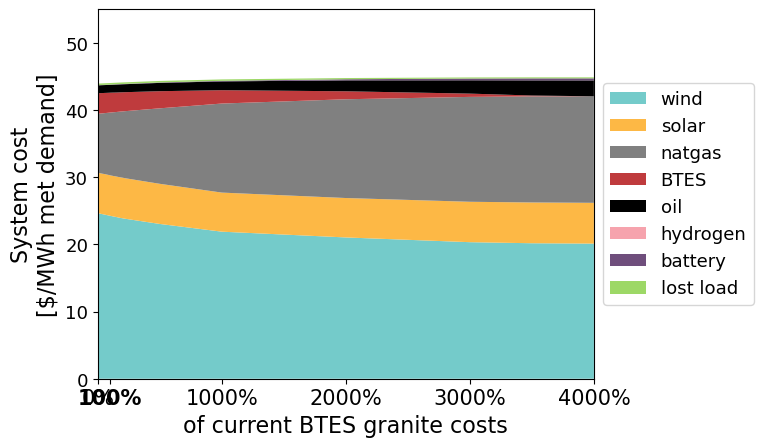

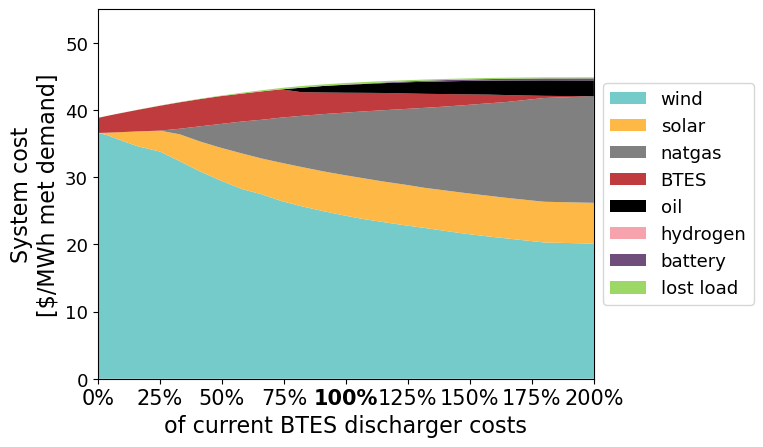

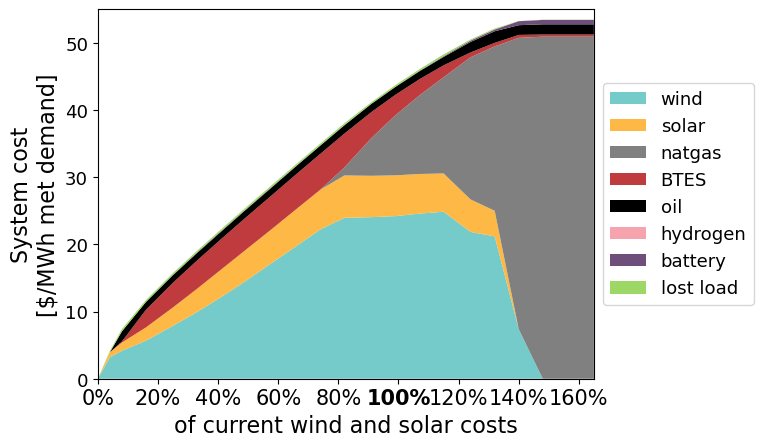

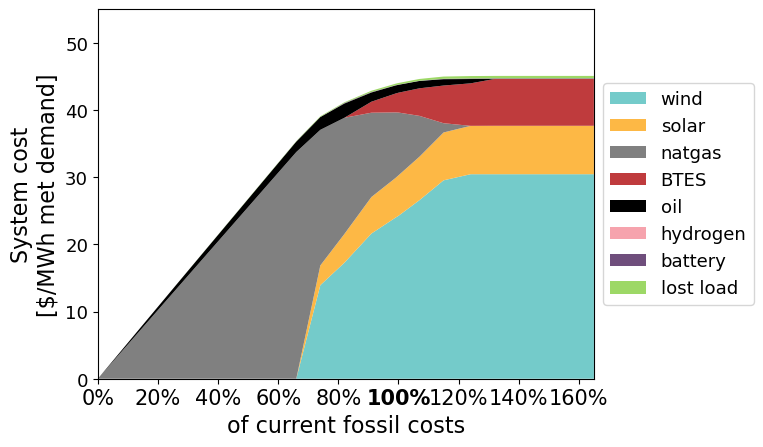

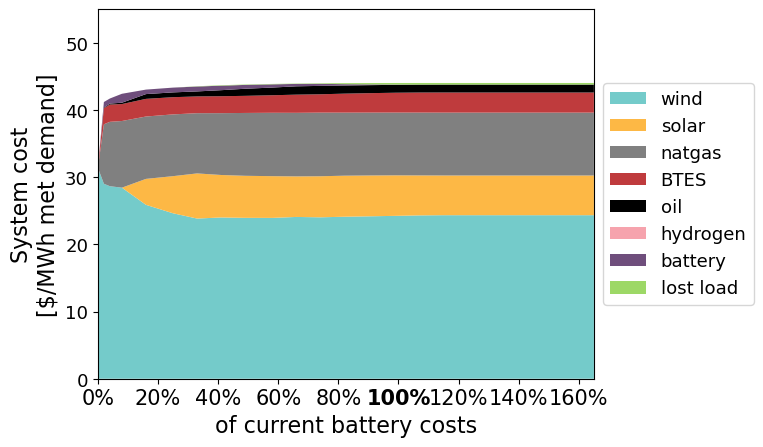

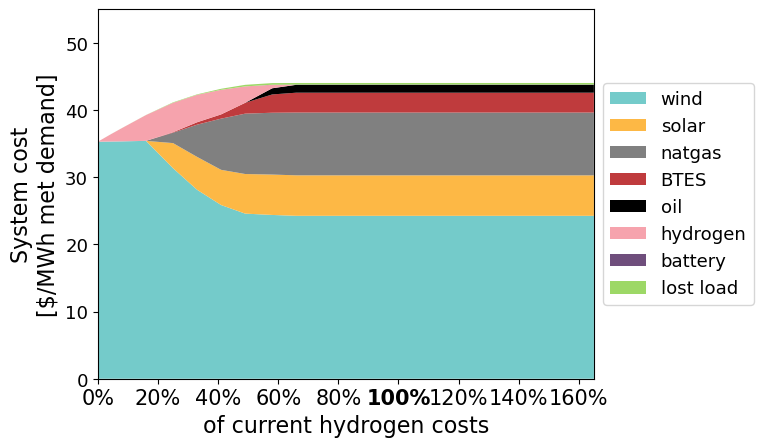

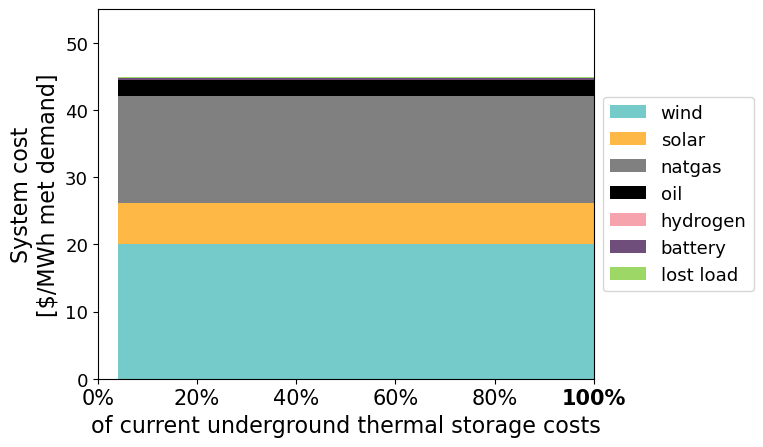

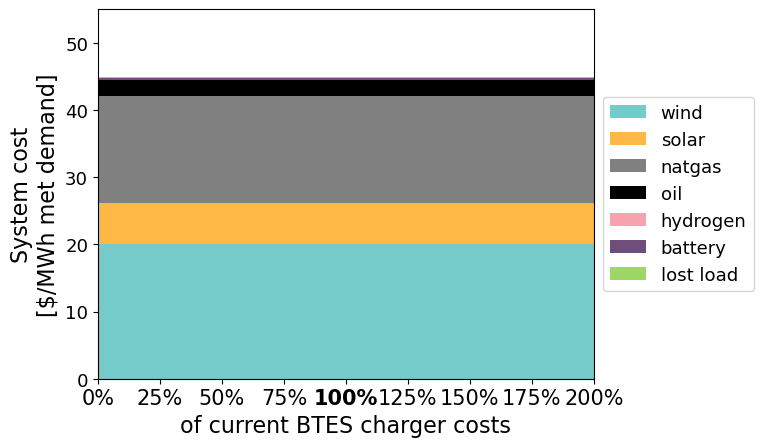

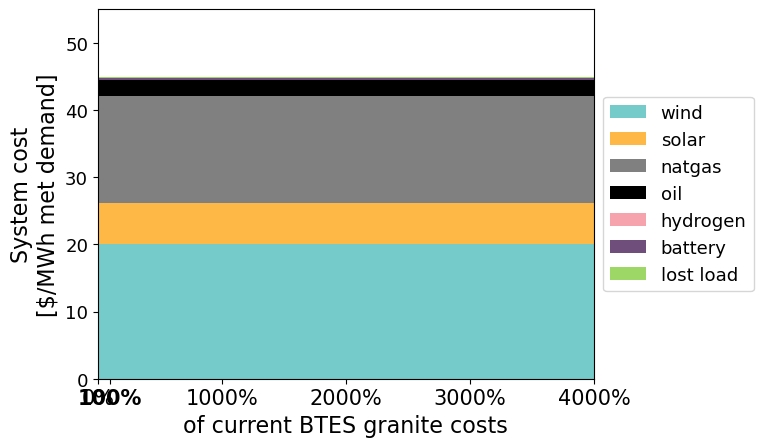

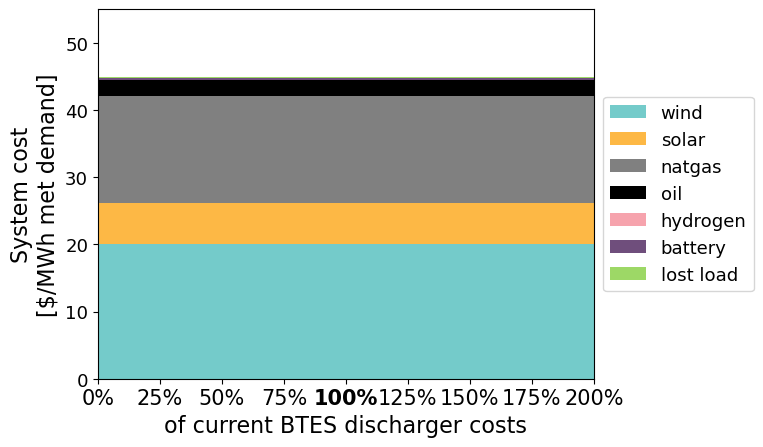

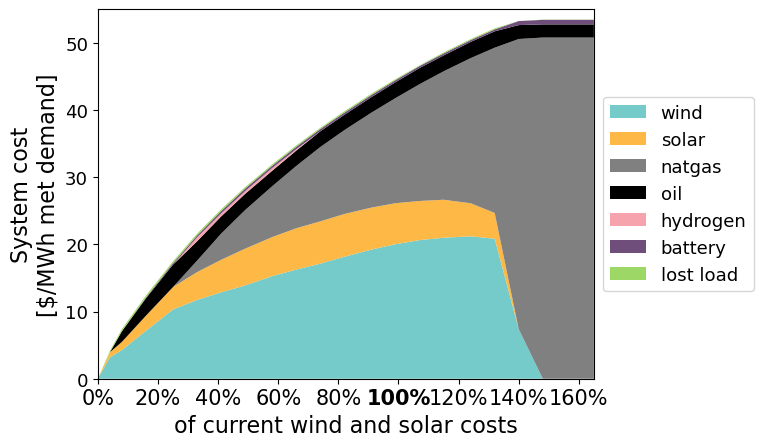

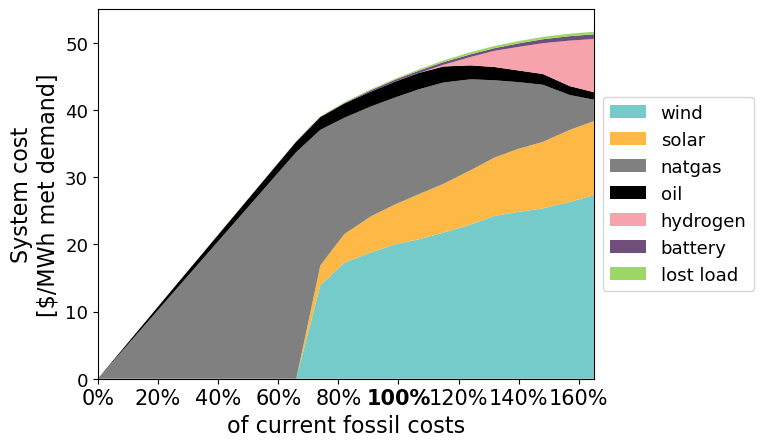

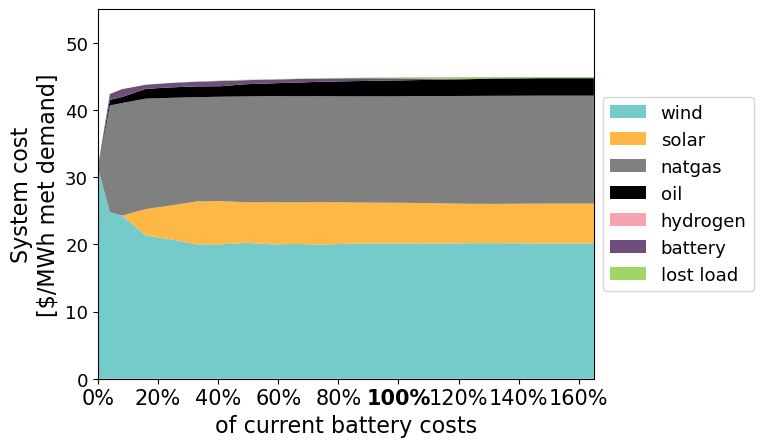

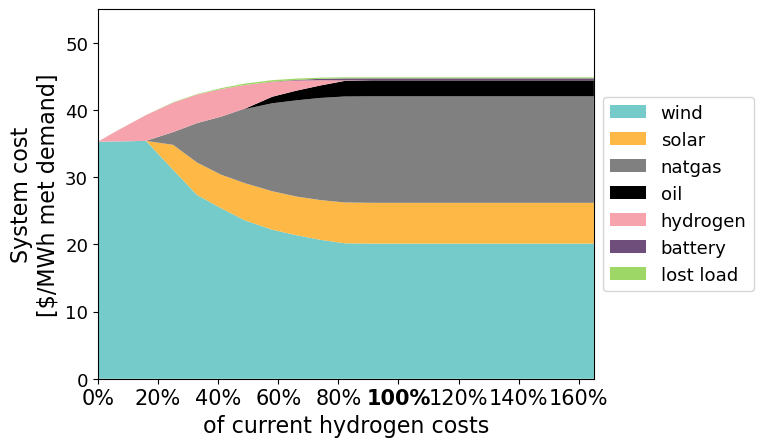

In [11]:
for path in [data_path, data_path+'_no_btes']:
    for tech in ['BTES', 'BTES_charger', 'BTES_granite', 'BTES_discharger', 'wind_solar', 'fossil', 'battery', 'hydrogen']:
        plot_cost_scan(path, "conus", tech)

Cost factor:  1p0
Discharger dispatch 9340440.229688749
Cost factor:  1p32
Discharger dispatch 26536828.34387202
Cost factor:  1p65
Discharger dispatch 1001988.2296759237


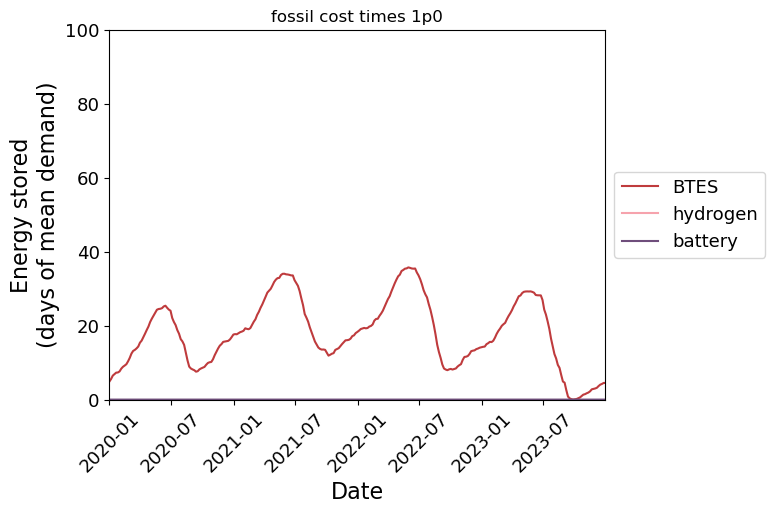

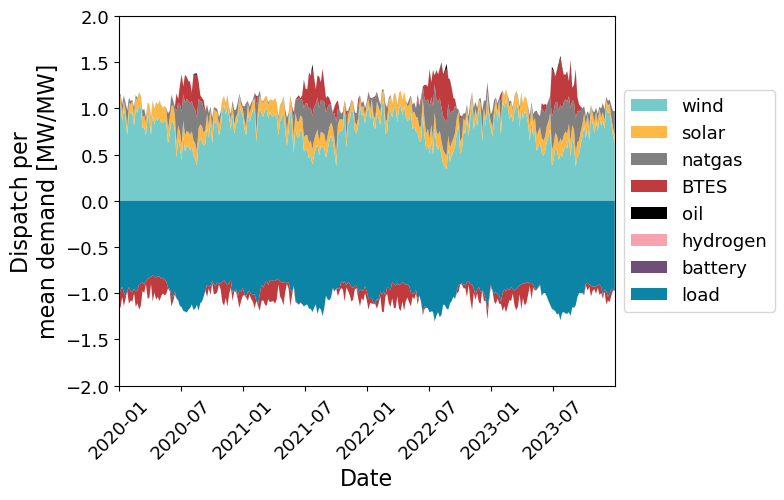

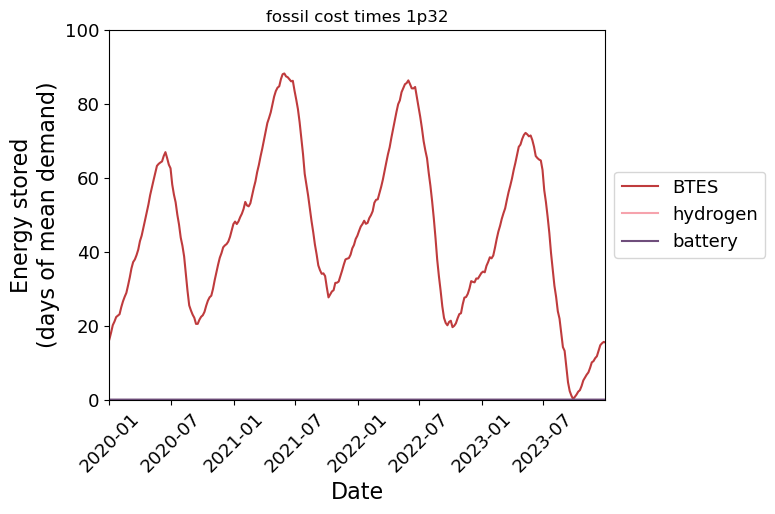

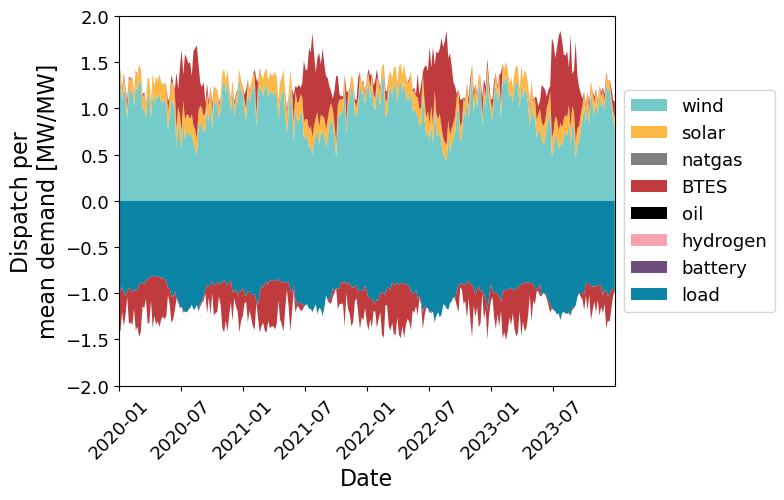

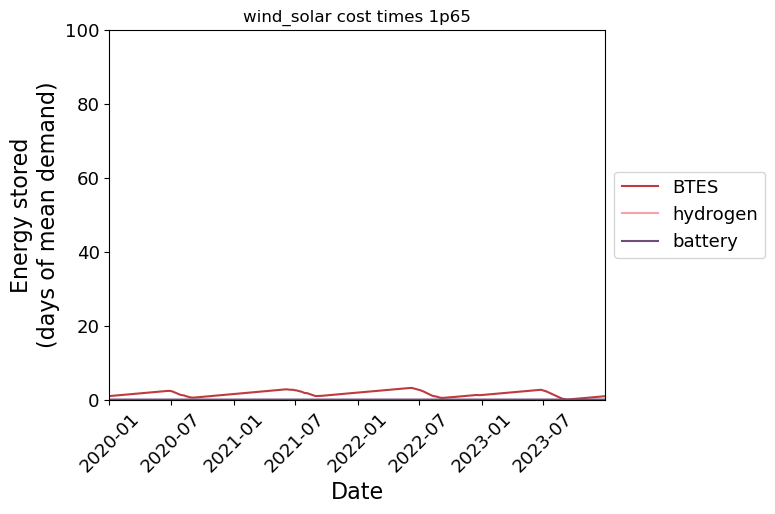

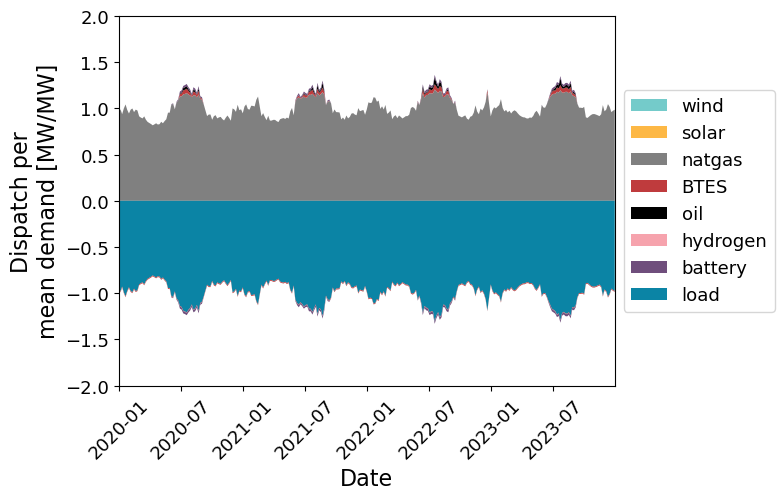

In [12]:
# Plot dispatch and energy stored for BTES
for cost_factor in ['1p0', '1p32', '1p65']:
    print("Cost factor: ", cost_factor)
    var = 'fossil' if not cost_factor == '1p65' else 'wind_solar'
    data_file = f'output_data/btes_base_case_orca/btes_output_{var}_costsx{cost_factor}.pickle'
    res_data = read_file(data_file)
    energy_stored_plot(res_data, cost_factor, 'conus', f'{var} cost times {cost_factor}')
    dispatch_plots(res_data, cost_factor, 'conus', f'{var} cost times {cost_factor}')